In [7]:
% matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import netCDF4
import shutil
from numba.decorators import jit
from datetime import datetime

import romspy
from romspy.make import make_ini_zero
import seasonal

In [2]:
ncfile = '/home/okada/ism-i/apps/OB500P/param_v1/NL1/ob500_his_0001.nc'
grdfile = '/home/okada/Data/ob500_grd-11_3.nc'
mapfile = '/home/okada/romspy/romspy/deg_OsakaBayMap_okada.bln'

nc = romspy.hview.Dataset(ncfile, grdfile, mapfile)

nc.check_time()

check_time(which=ends, name=ocean_time, tunit=seconds since 1968-05-23 09:00:00 GMT)
2012-01-01 00:00:00 0
2012-02-01 00:00:00 31


In [30]:
@jit
def moving_mean_jit(a, r=3):
    m = np.zeros_like(a)
    for i in range(len(a)):
        if i < r:
            m[i] = np.mean(a[:i+r])
        elif i > 31-r:
            m[i] = np.mean(a[i-r:])
        elif i >= r:
            m[i] = np.mean(a[i-r:i+r])
    return m

def cal_std(var):
    tmax, kmax, jmax, imax = var.shape
    v_std = np.zeros((kmax, jmax, imax))
    for k in xrange(kmax):
        print k,
        for i in xrange(imax):
            for j in xrange(jmax):
                v = var[:,k,j,i]
                if v[-1] < 1000:
                    mm = moving_mean_jit(v, r=5)
                    v_std[k,j,i] = np.std(v - mm)
                else:
                    v_std[k,j,i] = np.NaN
    return v_std

vnames = ['temp']
var_std = {}
for vname in vnames:
    print '\n', vname
    #var_std[vname] = cal_std(nc.nc[vname])

 
temp


In [31]:
vnames = nc.nc.variables.keys()
for vname in vnames:
    if nc.nc[vname].ndim == 4:
        print "'{}',".format(vname),

'u', 'v', 'u_eastward', 'v_northward', 'w', 'temp', 'salt', 'NO3', 'NH4', 'chlorophyll', 'phytoplankton', 'zooplankton', 'LdetritusN', 'SdetritusN', 'oxygen', 'PO4', 'LdetritusP', 'SdetritusP', 'AKv', 'AKt', 'AKs', 'tke', 'gls',


In [32]:
vnames = ['temp', 'salt', 'NO3', 'NH4', 'chlorophyll', 'phytoplankton', 'zooplankton', 
          'LdetritusN', 'SdetritusN', 'oxygen', 'PO4', 'LdetritusP', 'SdetritusP']

var_std = {}
for vname in vnames:
    print '\n', vname
    var_std[vname] = cal_std(nc.nc[vname])


temp
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
salt
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
NO3
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
NH4
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
chlorophyll
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
phytoplankton
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
zooplankton
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
LdetritusN
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
SdetritusN
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
oxygen
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
PO4
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
LdetritusP
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
SdetritusP
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19


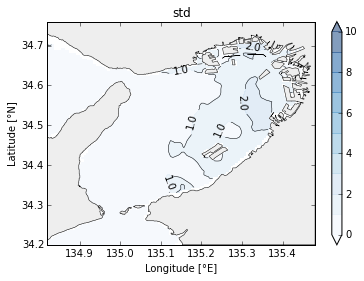

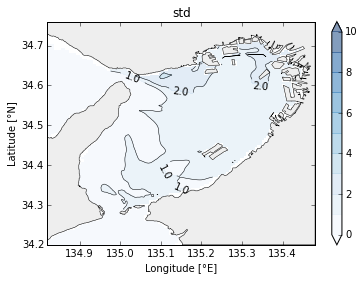

In [37]:
vname = 'chlorophyll'
levels = np.arange(0,10.1,1)
#vname = 'oxygen'
#levels = np.arange(0,21.1,3)

nc._hview(var_std[vname][0], 'std', fmt='%.1f', levels=levels)
plt.show()
nc._hview(var_std[vname][-1], 'std', fmt='%.1f', levels=levels)
plt.show()

In [38]:


stdfile = '/home/okada/Data/ob500_std_i_param_v1_NL1_0001.nc'
make_ini_zero(grdfile, stdfile, dstart=datetime(2012,1,16,0,0), biofile=True)

In [39]:
std = netCDF4.Dataset(stdfile, 'a')
for vname in vnames:
    std[vname][:] = var_std[vname]
std.close()